In [ ]:
import glob
import re

import xarray as xr
import matplotlib.pyplot as plt
%matplotlib inline

import dask
import xbatcher

from src.utils import open_ras, open_cloud, to_bin_string, check_bit


In [ ]:
from dask.distributed import Client, LocalCluster
cluster = LocalCluster(n_workers=8)
client = Client(cluster)
cluster.dashboard_link


### open files and concat in single xarray

In [ ]:
# list files
files = glob.glob('tif/Sentinel2L2A_sen2cor_*.tif')
cfiles = glob.glob('clouds/cloud_mask_*.tif')

# open reflectance
xrs = [open_ras(f) for f in files]
xrsc = xr.concat(xrs, dim='tile')
# this band has too much nodata
xrsc = xrsc.where(xrsc.band < 11, drop=True)
xrsc = xrsc.drop('spatial_ref')
xrsc = xrsc.rename({'band_data': 'reflectance'})

# open clouds
xrc = [open_cloud(f) for f in cfiles]
xrcc = xr.concat(xrc, dim='tile')
xrcc = xrcc.drop('spatial_ref')
xrcc = xrcc.rename({'band_data': 'label'})


In [ ]:
# minmax scaling
minn = xrsc.min(dim=['x', 'y', 'tile']).compute()
maxx = xrsc.max(dim=['x', 'y', 'tile']).compute()
xrsc = (xrsc - minn)/(maxx-minn)

# export for use on when predicting
minmax = minn.rename({'band_data': 'min'}).merge(
    maxx.rename({'band_data': 'max'}))
minmax.to_zarr('data/minmax.zarr')

#TODO: change to using qunatiles for scaling
#i tried this but kept getting OOM errors
#then I realized that lots of nan in the data makes the computation crash


### reclassify cloud masks into cloud/no cloud

In [ ]:

# get unique values
cvals_da = dask.array.unique(xrcc['label'].data)
vals = cvals_da.compute()

# convert to binary string
val8 = [to_bin_string(x) for x in vals]

# all cloud ex thinnest bit 1
allc = [int(check_bit(x, 1)) for x in val8]
# thin clouds bit 4
thinc = [int(check_bit(x, 4)) for x in val8]
# high clouds bit 7
highc = [int(check_bit(x, 7)) for x in val8]

# sum and convert to logical
sumcloud = [sum(x) for x in zip(allc, thinc, highc)]
cloud_log = [x > 0 for x in sumcloud]

# select the codes for clouds
cloudints = vals[cloud_log]

# reclassify
xrccr = xrcc.isin(cloudints)
xrccr = xrccr.chunk({'tile': 1, 'x': -1, 'y': -1})
# convert logical to int
xrccr['label'] = xrccr['label'].astype('int8')


### merge reflectance and clouds

In [ ]:
xrm = xrsc.merge(xrccr)

# you might need to save here to prevent the dask graph getting out of control
#xrm = xrm.chunk({'tile':1,'band':1,'x': -1, 'y': -1})
# xrm.to_zarr('data/merged.zarr')
#xrm = xr.open_zarr('data/merged.zarr')

### data viz

#### compare rgb and cloud mask

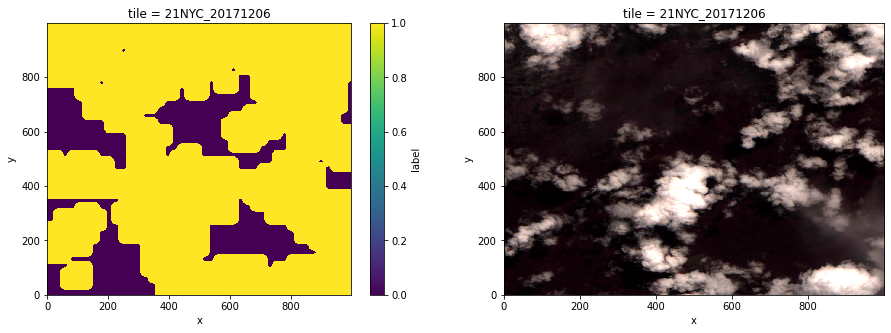

In [9]:
# subset
xpltc = xrm.sel(x=slice(0, 1000), y=slice(0, 1000), tile='21NYC_20171206')

# combine plots into single figure
fig, ax = plt.subplots(1, 2, figsize=(15, 5))
xpltc['label'].plot(ax=ax[0])
#i think bands 2 1 0 are rgb?
xpltc['reflectance'][[2,1,0],:,:].plot.imshow(
    rgb='band', robust=True, ax=ax[1])


#### histograms of class freqs and data

(array([196049.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 803951.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

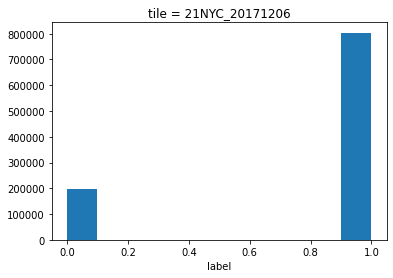

In [10]:
# class freqs
xpltc['label'].plot.hist()


(array([611010., 122315.,  80495.,  62374.,  50579.,  34694.,  20980.,
         12783.,   4063.,    707.]),
 array([0.00530821, 0.07252642, 0.13974462, 0.20696284, 0.27418104,
        0.34139925, 0.40861747, 0.47583568, 0.54305387, 0.6102721 ,
        0.6774903 ], dtype=float32),
 <BarContainer object of 10 artists>)

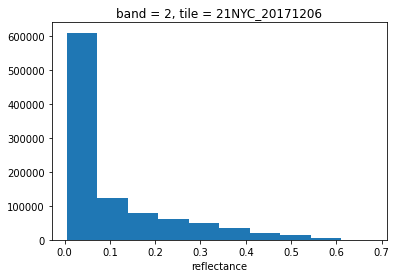

In [11]:
# data
xpltc['reflectance'].sel(band=2).plot.hist()


### reshape and chip data

In [ ]:
xdim, ydim, bdim, tdim = "x", "y", "band", "tile"
patch = 256
nband = 10
ntile = 12

# this controls how many tiles will be combined in the generator
batchdim = 10980//5

# create generator
batch_gen_test = xbatcher.BatchGenerator(
    xrm,
    input_dims={xdim: patch, ydim: patch, bdim: nband, tdim: ntile},
    batch_dims={xdim: batchdim, ydim: batchdim, bdim: nband, tdim: ntile},
    concat_input_dims=True,
    preload_batch=False
)


In [ ]:
# iterate and save chips to zarr
i = 0
for xb in batch_gen_test:
    i = i+1
    cname = f'data/chips/cloud_chips_{i}.zarr'
    xb.to_zarr(cname)
    print(f'done with {i}')


### combine all chips for train/val/test

we do this so that the dataloader has to do as little work as possible  
this should be combined with the previous step

In [ ]:
# open chips as single xarray
dar = xr.open_mfdataset('data/chips/cloud_chips_*.zarr',
                        combine='nested', concat_dim='input_batch')
dar = dar.set_index({'tile_input': 'tile', 'band_input': 'band'})

# this might be faster
#dar = [open_ras(f) for f in glob.glob('data/chips/cloud_chips_*.zarr')]
#dar = xr.concat(dar,dim='input_batch')


In [ ]:
# write to zarr
# each sample is in a separate chunk for fast loading

# val
output_clean_chips(
    dar, ['29RPP_20180206', '49RFN_20190806'], 'data/val_cloud.zarr')
# train
output_clean_chips(dar, ['18TUR_20180812', '21NYC_20171206', '28PDU_20171002',
                         '28PDU_20180609', '31PDM_20190911', '31TCG_20171030',
                         '32SNC_20181202', '33TVF_20191104', '58KFC_20181021'], 'data/train_cloud.zarr')
# test
output_clean_chips(dar, ['30TXR_20190618'], 'data/test_cloud.zarr')
